# El objetivo de este notebook es calcular el Bispectrum 1D en el bosque de Ly-$\alpha$ usando los Mocks simulados por DESI, específicamente los siulados por SIMQSO.

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import fitsio 
import sys
from scipy.fftpack import fft
from glob import glob
#sys.path.append('/home/rodrigo/Documentos/env_pru/empca/') # solo si se usa para obtener el continuum flux, pero 
                                                            # en DR9 ya viene el continuum flux.
#import empca
%matplotlib inline
#%pylab inline

Se requerirá de una función que haga una interpolación. Esta función se obtuvo de [desispec](https://github.com/desihub/desispec).

In [3]:
def resample_flux(xout, x, flux, ivar=None, extrapolate=False):
    if ivar is None:
        return _unweighted_resample(xout, x, flux, extrapolate=extrapolate)
    else:
        if extrapolate :
            raise ValueError("Cannot extrapolate ivar. Either set ivar=None and extrapolate=True or the opposite")
        a = _unweighted_resample(xout, x, flux*ivar, extrapolate=False)
        b = _unweighted_resample(xout, x, ivar, extrapolate=False)
        mask = (b>0)
        outflux = np.zeros(a.shape)
        outflux[mask] = a[mask] / b[mask]
        dx = np.gradient(x)
        dxout = np.gradient(xout)
        outivar = _unweighted_resample(xout, x, ivar/dx)*dxout
        
        return outflux, outivar

def _unweighted_resample(output_x,input_x,input_flux_density, extrapolate=False) :
    
    # shorter names
    ix=input_x
    iy=input_flux_density
    ox=output_x

    # boundary of output bins
    bins=np.zeros(ox.size+1)
    bins[1:-1]=(ox[:-1]+ox[1:])/2.
    bins[0]=1.5*ox[0]-0.5*ox[1]     # = ox[0]-(ox[1]-ox[0])/2
    bins[-1]=1.5*ox[-1]-0.5*ox[-2]  # = ox[-1]+(ox[-1]-ox[-2])/2
    
    tx=bins.copy()
    if not extrapolate :
        # note we have to keep the array sorted here because we are going to use it for interpolation
        ix = np.append( 2*ix[0]-ix[1] , ix)
        iy = np.append(0.,iy)
        ix = np.append(ix, 2*ix[-1]-ix[-2])
        iy = np.append(iy, 0.)

    ty=np.interp(tx,ix,iy)
    
    #  add input nodes which are inside the node array
    k=np.where((ix>=tx[0])&(ix<=tx[-1]))[0]
    if k.size :
        tx=np.append(tx,ix[k])
        ty=np.append(ty,iy[k])
        
    # sort this node array
    p = tx.argsort()
    tx=tx[p]
    ty=ty[p]
    
    trapeze_integrals=(ty[1:]+ty[:-1])*(tx[1:]-tx[:-1])/2.
    
    trapeze_centers=(tx[1:]+tx[:-1])/2.
    binsize = bins[1:]-bins[:-1]

    if np.any(binsize<=0)  :
        raise ValueError("Zero or negative bin size")
    
    return np.histogram(trapeze_centers, bins=bins, weights=trapeze_integrals)[0] / binsize

In [4]:
transs = '/home/rodrigo/Documentos/doctorado/Datos_mocks_desi/spectra_data/transmission/spectra.fits'
contin = '/home/rodrigo/Documentos/doctorado/Datos_mocks_desi/spectra_data/continuum/spectra.fits'

In [26]:
### Especctros con transmision, sin ruido (alto tiempo de exposicion)
bwavetrans = fitsio.read(transs, 'B_WAVELENGTH')
bfluxtrans = fitsio.read(transs,'B_FLUX')
bivertrans = fitsio.read(transs,'B_IVAR')
### Espectros con el continuo
bwaveconti = fitsio.read(contin, 'B_WAVELENGTH')
bfluxconti = fitsio.read(contin,'B_FLUX')

In [8]:
print('Num. de espectros = {}'.format(bfluxtrans.shape[0]),'. Con corrimientos al rojo entre 2.8 y 3.0.')

Num. de espectros = 161 . Con corrimientos al rojo entre 2.8 y 3.0.


Debemos concer el corrimiento al rojo de cada espectro.

In [20]:
zfilename = contin.replace('spectra.fits', 'zbest-16-0.fits') 
zs = fitsio.read(zfilename) # zbest file.
z = zs['Z']

Lo primero es cortar los espectros para quedarnos solo con la region de Ly-$\alpha$.

In [32]:
mwave = []
mflux = []
mivar = []
mcont = []
for i in range(len(z)):
    waverf = bwaveconti/(1+z[i])
    maskrf = (waverf > 1040) & (waverf < 1200) # región del bosque de Lyalpha
    mwave.append(waverf[maskrf])
    mflux.append(bfluxtrans[i][maskrf])
    mivar.append(bivertrans[i][maskrf])
    mcont.append(bfluxconti[i][maskrf])

Ahora normalicemos los espectros.

In [41]:
lmin=1040.0
lmax=1199.0

mintegral = []
mcont_nor = []
mflux_nor = []
mivar_nor = []
for i in range(len(mwave)):
    #msum1=0
    msum2=0
    for j in range(len(mwave[i])):
        if lmin <= mwave[i][j] < lmax :
            #msum1+=(mcont[i][j])*(mwave[i][j+1]-mwave[i][j]) # Si lo uso, entonces el continuo se mueve del espectro.
            msum2+=(mflux[i][j])*(mwave[i][j+1]-mwave[i][j])
        else:
            break
    mintegral.append(msum2)
    mcont_nor.append(mcont[i]/msum2)
    mflux_nor.append(mflux[i]/msum2)
    mivar_nor.append((mivar[i])*((msum2)**2))

### Campo de deltas.

Recordemos la definición de las deltas.

\begin{equation}
\delta(\lambda) = \frac{F(\lambda)}{\overline{F}(\lambda)} - 1 = \frac{f(\lambda)}{C(\lambda)\overline{F}(\lambda)} - 1,
\end{equation}

donde $F(\lambda) = \dfrac{f(\lambda)}{C(\lambda)}$ es el flujo transmitido o transmisión y $f(\lambda)$ el flujo medido y $C(\lambda)$ es el espectro continuo de los QSO.

In [49]:
print('Anchura aproxinada Δλ de los espectros base = ',mwave[1][1]-mwave[1][0])

Anchura aproxinada Δλ de los espectros base =  0.2019928907391204


In [69]:
CRVAL1 = 2.6534
CDELT1 = 0.000085 #0.0001 para BOSS DR14, per que tambien use para DR9
NBLL   = 13637
mwwave = 10**(CRVAL1+np.arange(NBLL)*CDELT1)
masw = (wwave > 1040) & (wwave < 1200)
mwwave = wwave[masw]

Interpolar los datos.

In [70]:
mfluxc  = np.zeros((len(mflux_nor), mwwave.size))
mivarc  = np.zeros((len(mflux_nor), mwwave.size))
mcontc  = np.zeros((len(mflux_nor), mwwave.size))

for i in range(len(mflux_nor)):
    mfluxc[i], mivarc[i] = resample_flux(mwwave,mwave[i],mflux_nor[i], mivar_nor[i]) # interpolation 
    mcontc[i] = resample_flux(mwwave,mwave[i],mcont_nor[i])

In [71]:
 print('Shape wave            = {} \nlong. Shape flujo     = {} \nlong. Shape continuo  = {} \nlong. Shape ivar      = {}'.format(mwwave.shape,mfluxc.shape, mcontc.shape, mivarc.shape))

Shape wave            = (731,) 
long. Shape flujo     = (161, 731) 
long. Shape continuo  = (161, 731) 
long. Shape ivar      = (161, 731)


In [72]:
mivarc[mivarc<0.] = 0               #
mw = sp.sum(mivarc,axis=0)>0.       #
mwwave = mwwave[mw]                 # For the noise.
mfluxc = mfluxc[:,mw]               #
mivarc = mivarc[:,mw]               #
mcontc = mcontc[:,mw]               #
mivarc[mivarc>100.] = 100.          #

In [75]:
def deltas(dflujo, dcont, dnoise):
    F = np.zeros((dflujo.shape))              # Transmision
    for i in range(len(dflujo)):
        F[i] = dflujo[i]/dcont[i]
    Fmean = np.average(F, weights = dnoise, axis = 0)          #Transmision promedio  
    delta = F/Fmean - 1                      #Delta
    Dmean = np.average(delta, weights = dnoise, axis = 0)
    return F, Fmean, delta, Dmean

In [76]:
mT, mTprom, mdelt, mdeltprom = deltas(mfluxc,mcontc,mivarc)

Veamos las transmisiones y la transmision promedio para los mocks

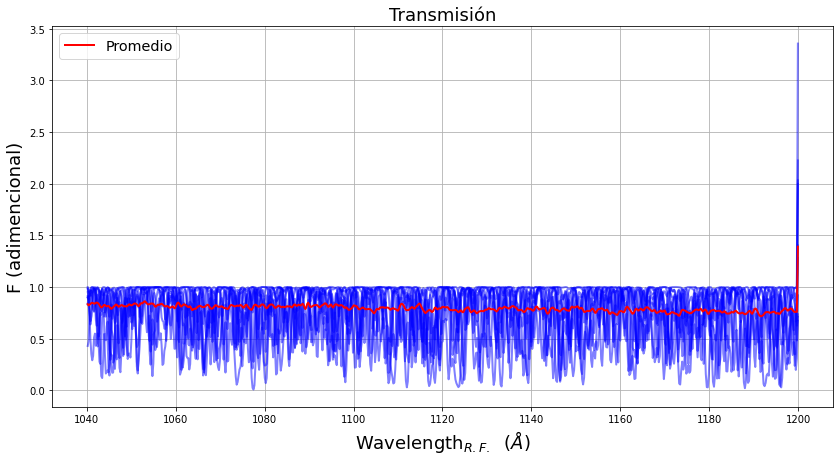

In [77]:
plt.figure(figsize=(14,7))
plt.title('Transmisión',fontsize = 18)
for k in range(len(mfluxc))[:10]:
    plt.plot(mwwave,mT[k], color='b',linewidth=2.0,alpha=0.5)
plt.plot(mwwave,mTprom, color='r',label='Promedio',linewidth=2.0,alpha=1)
plt.xlabel('Wavelength$_{R.F.}$  ($\AA$)',fontsize = 18)
plt.ylabel('F (adimencional)',fontsize = 18)
plt.legend(fontsize='x-large')
plt.grid()

Ahora para las deltas y la deta promedio.

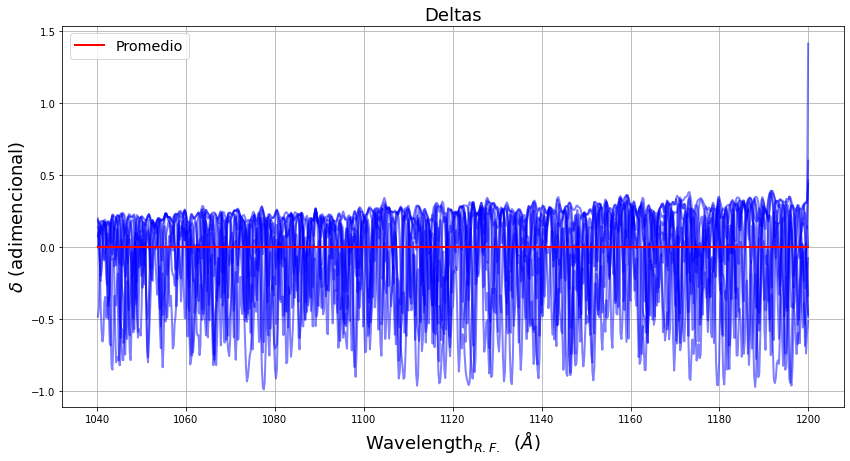

In [79]:
plt.figure(figsize=(14,7))
plt.title('Deltas',fontsize = 18)
for k in range(len(mfluxc))[:10]:
    plt.plot(mwwave,mdelt[k], color='b',linewidth=2.0,alpha=0.5)
plt.plot(mwwave,mdeltprom, color='r',label='Promedio',linewidth=2.0,alpha=1)
plt.xlabel('Wavelength$_{R.F.}$  ($\AA$)',fontsize = 18)
plt.ylabel('$\delta$ (adimencional)',fontsize = 18)
plt.legend(fontsize='x-large')
plt.grid()

Como se puede ver el promedio de $\delta$ está sobre cero y las diferencias se ven a orden $10^{-16}$.

Dado que  $\Delta\log(\lambda) = 1 × 10^{-4}$ e igualmente espaciada para todos los pixels (entiendase esta vez como separación entre longitudes de onda). Lo importante es que esten igualmente espaciadas.

In [83]:
mlogwave = np.log10(mwwave)
print('Δlog(λ) = ', mlogwave[1]-mlogwave[0])

Δlog(λ) =  8.499999999989072e-05


Mientras que la diferencia de velocidades entre pixels o velocidad relativa de las líneas de absorción (como función de longitudes de onda).

\begin{equation}
\Delta v (\lambda) = c\Delta z = c \dfrac{\Delta \lambda}{\lambda} = c \Delta[Ln(\lambda)] = c Ln(10)\Delta[\log(\lambda)],
\end{equation}
donde $c$ es la velocidad de la luz. c = 300,000 km/s.

In [84]:
from scipy.constants import speed_of_light as speed_light
print('c = ', speed_light,'m/s')
mDv = (speed_light/1000.0)*np.log(10)*(mlogwave[1]-mlogwave[0])
#Dv = (speed_light/1000.0)*np.log(10)*len(delt[0])*(logwave[1]-logwave[0])
print('Δv(λ) = ', mDv,'km/s')

c =  299792458.0 m/s
Δv(λ) =  58.67529980646626 km/s


Ahora se debe cambiar $\delta(\lambda) \rightarrow \delta(\Delta v)$ 

## Calcular el 1D Power Spectrum

Lo que se debe hacer es aplicar la transformada de Fourier al campo $\delta(\Delta v)$, donde el vector de onda será $k = \dfrac{2\pi}{\Delta v}$ cuyas unidades son $(km/s)^{-1}$.

In [85]:
def pkraw(vel, deltasv):
    ####
    nb_pixels = len(deltasv[0])
    nbin_fft = nb_pixels//2 + 1
    Pk = np.zeros((len(deltasv),nbin_fft))
    delkd = []
    for i in range(len(deltasv)):
        #Hacer FFT
        fftdelta = fft(deltasv[i])
        #Calcular 1DPS
        fftdelta = fftdelta[:nbin_fft]
        Pk[i] = (fftdelta.real**2 + fftdelta.imag**2) * (vel*nb_pixels)/(nb_pixels**2)
        delkd.append(fftdelta)
    deltk = np.vstack(delkd)
    Pkm = sp.average(Pk, axis=0)
    #std = np.std(Pk, axis = 0 ) 
    k = np.arange(nbin_fft,dtype=float)*2*sp.pi/(vel*nb_pixels)                       #  k=2π/Δv
    return k, Pkm, Pk, deltk

In [86]:
def pk1noise(vel, deltasvv):
    ####
    nb_pixels = len(deltasvv)
    nbin_fft = nb_pixels//2 + 1
    #Hacer FFT
    fftdelta = fft(deltasvv)
    #Calcular 1DPS
    fftdelta = fftdelta[:nbin_fft]
    Pk = (fftdelta.real**2 + fftdelta.imag**2) * (vel*nb_pixels)/(nb_pixels**2)
    k = np.arange(nbin_fft,dtype=float)*2*sp.pi/(vel*nb_pixels)                       #  k=2π/Δv
    return k, Pk, fftdelta

In [87]:
def pknoise(vel,noise):
    ####
    nb_pixels = len(noise[0])
    nbin_fft = nb_pixels//2 + 1
    pknois = np.zeros((len(noise),nbin_fft))
    delkiv = []
    #
    for i in range(len(noise)):
        nb_noise_exp = 10
        Pk = np.zeros(nbin_fft)
        delknoise = []
        err = np.zeros(nb_pixels)
        noises = noise[i]
        w = noises>0
        err[w] = 1.0/np.sqrt(noises[w])
        for j in range(nb_noise_exp):
            delta_exp= np.zeros(nb_pixels)
            delta_exp[w] = sp.random.normal(0.,err[w])
            j,Pk_exp, deltasnoise = pk1noise(vel,delta_exp) #k_exp unused, but needed
            Pk += Pk_exp
            delknoise.append(deltasnoise)
        Pk /= float(nb_noise_exp)
        delknoise = np.vstack(delknoise)
        delknoise = np.sum(delknoise,axis=0)/float(nb_noise_exp)
        pknois[i] = Pk
        delkiv.append(delknoise)
    Pknoises = np.average(pknois, axis=0)
    delkiv = np.vstack(delkiv)
    delknoises = np.average(delkiv, axis=0)
    return Pknoises, pknois, delkiv

El espectro de potencias 1D se expresa como:

\begin{equation}
P_{1D}(k) = \langle \dfrac{P^{raw}(k) - P^{noise}(k)}{W^{2}(k,R,\Delta v)} \rangle,
\end{equation}

donde $R$ es la resolución del espectrógrafo, $P^{raw}(k) = |F(\delta(\Delta v))|^{2}$ y $P^{noise}(k) = |F(n(\Delta v))|^{2}$. W es una función ventana correspondiente a la respuesta espectral del espectrógrafo, cuya forma es:

\begin{equation}
W(k,R,\Delta v) = \exp(-\dfrac{(kR)^2}{2})× \dfrac{\sin(k\Delta v / 2)}{k\Delta v / 2}
\end{equation}

In [88]:
mk1d, mPkraw_mean, mPkraws, mPdelk = pkraw(mDv, mdelt)

In [91]:
mPk_noise_mean, mPknoises, mDkiv = pknoise(mDv, mivarc)

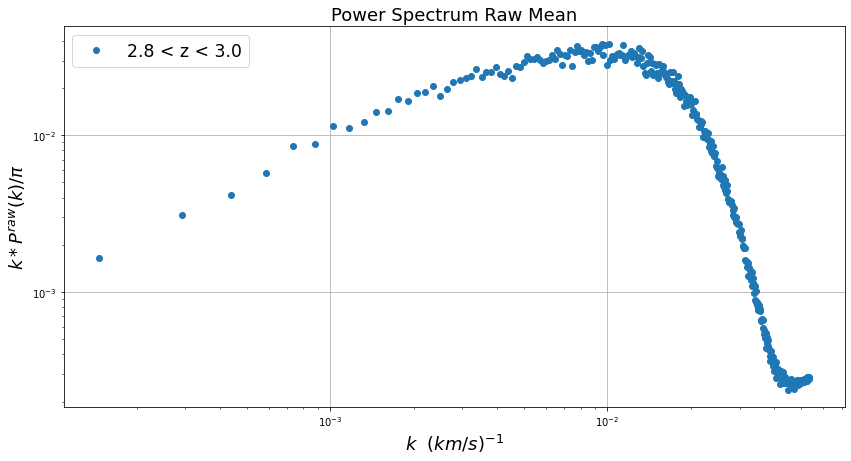

In [92]:
plt.figure(figsize=(14,7))
plt.title('Power Spectrum Raw Mean',fontsize = 18)
plt.plot(mk1d,mk1d*mPkraw_mean/np.pi,'o', label = '2.8 < z < 3.0')
#plt.errorbar(k1d,k1d*Pk1d/np.pi,yerr=stdPk, fmt='o',ecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$k*P^{raw}(k)/\pi$',fontsize = 18)
plt.legend(fontsize='xx-large')
plt.grid()

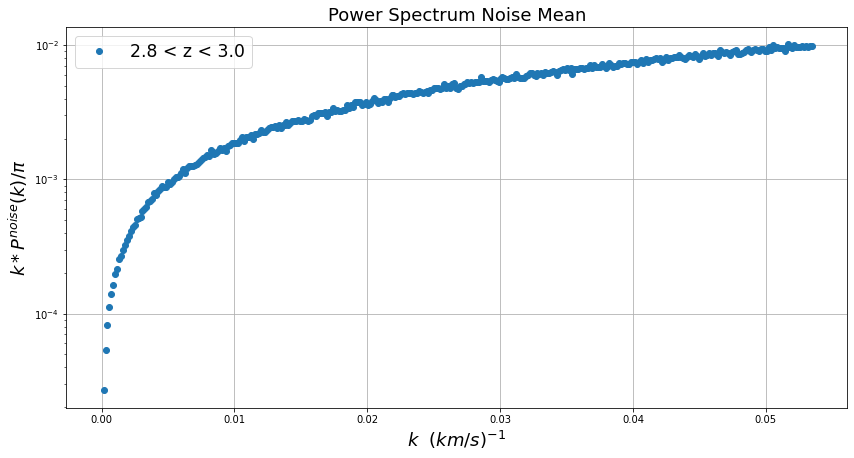

In [93]:
plt.figure(figsize=(14,7))
plt.title('Power Spectrum Noise Mean',fontsize = 18)
plt.plot(mk1d,mk1d*mPk_noise_mean/np.pi,'o', label = '2.8 < z < 3.0')
#plt.errorbar(k1d,k1d*Pk1d/np.pi,yerr=stdPk, fmt='o',ecolor='black')
plt.yscale('log')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$k*P^{noise}(k)/\pi$',fontsize = 18)
plt.legend(fontsize='xx-large')
plt.grid()

In [94]:
def window(vel, reso, kvec):
    nb_bin_FFT = len(kvec)
    cor = np.ones(nb_bin_FFT)

    sinc = np.ones(nb_bin_FFT)
    sinc[kvec>0.] = sp.sin(kvec[kvec>0.]*vel/2.0)/(kvec[kvec>0.]*vel/2.0)

    cor *= sp.exp(-((kvec*reso)**2)/2.0)
    cor *= sinc
    Win = cor**2
    return Win

In [95]:
mwin = window(mDv,85,mk1d)

In [96]:
mPk1DT = (mPkraw_mean - mPk_noise_mean)/mwin

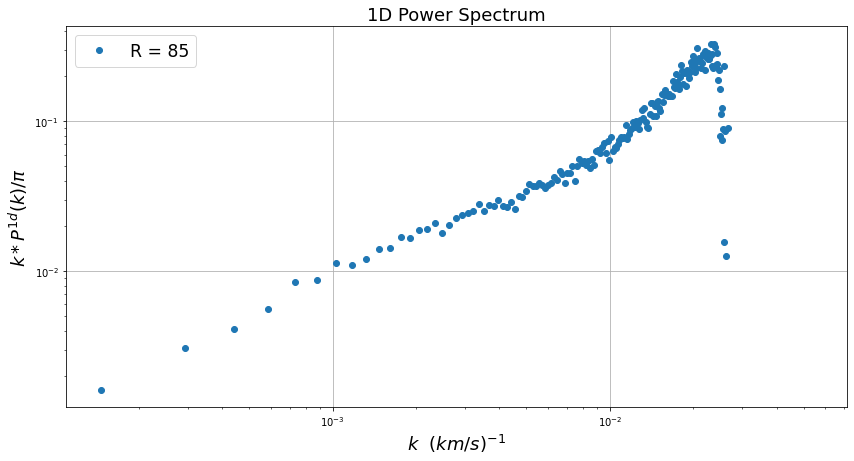

In [97]:
plt.figure(figsize=(14,7))
plt.title('1D Power Spectrum',fontsize = 18)
plt.plot(mk1d,mk1d*mPk1DT/np.pi,'o', label = 'R = 85')
#plt.errorbar(k1d,k1d*Pk1d/np.pi,yerr=stdPk, fmt='o',ecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$k*P^{1d}(k)/\pi$',fontsize = 18)
plt.legend(fontsize='xx-large')
plt.grid()

Ya tenemos el 1D Power Spectrum, pero lo que pretendemos es cálcular el 1D Bisepctrum y para eso debemos ver como definirlo. Siguiendo [Peebles_1980](https://press.princeton.edu/books/paperback/9780691209838/the-large-scale-structure-of-the-universe), se tiene que el Bispectrum es:
\begin{equation}
\langle \delta_{1} \delta_{2} \delta_{3} \rangle = \delta_{D}(k_{1}+k_{2}+k_{3})B(k_{1},k_{2},k_{3}),
\end{equation}
donde la delta de Dirac es impuesto por la invarianza de tradución dictada por la homogeneidad estadística. Esto asegura que el los números de onda **k$_{i}$** deben de ser los tres lados de un triángulo cerrado para contribuir al bispectrum, es decir, se cumple que **k$_{1}$** + **k$_{2}$** + **k$_{3}$** = 0. Debido a la isotropía estadística solo hay dependencia del modulo del vector, es decir, $k_{i}$ = |**k$_{i}$**|.

Esta cantidad mide directamente la evolución no lineal de los campos de densidad y velocidad y, por lo tanto, es rica en información del régimen no lineal. Así,
\begin{equation}
B(k_{1},k_{2},k_{3}) = B(k_{1},k_{2}) = \langle \delta(k_{1}) \delta(k_{2}) \delta(-k_{1}-k_{2}) \rangle.
\end{equation}

Además del Power Spectrum sabemos que $\delta(k) = \delta^{*}(-k)$, en cuyo caso, $\delta^{*}(k) = \delta(-k)$.

Comencemos por poner las Deltas en $\delta(-k)$.

In [98]:
mdelmk = mPdelk.conjugate()     # Para las deltas de flujo
mdelmkiv = mDkiv.conjugate()    # Para las deltas de ruido

In [99]:
print('Notemos que')
print('{} < k < {},'.format(np.min(mk1d), np.max(mk1d).round(15)))

Notemos que
0.0 < k < 0.053468750898061,


En los artículos ([Heavens_1997](https://watermark.silverchair.com/290-4-651.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAqowggKmBgkqhkiG9w0BBwagggKXMIICkwIBADCCAowGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMspi1-66wE5yIbPwlAgEQgIICXeR8ZLbuplwpAKyEt5mAqHYnkIiNwI-Ko8kjmCI04gsd0ig-wK89j-YtsFzrxiRM9hbeT0lJu7SZZYKRsZMP1FCFFE2ycki8I-IhypAqHhcu9zsI_y237gMBRqinFfCIRA6APlGjc6o4FcQOURwBOErJmrCNnEA3-i4fveaf6g4NNuoJZDRQItTMqxdJTbcnLIfCu6tsY-hFsxdeEUZ1MBr8L6kSxqCOgyhmcJtKlvnUxgEhFkm1WQf882i7IJ9lHvrkTH34XJBO5t1Hq7-JEiStBeV609zO4freCFKd5At4jvX8xN4FIZQoeAiUoRw1xH41fPDrU34Z-kOxcVqzsKzLirAFuTUV23IN1dnpSBuyWd5is99_4vEtXl_FElVO_MkYDhFcIMMkI3iROMsegsun-iMhwsuL93E1HDnmp5y24PrlmLRS5iINCr8GjbZwU-eBjf6R4AyqrUtscDyFkl4urBc4uYTyWBWTGVVBVBgmJrjTv1jf3qxXe5XyhDZ0UV1BRmfjMLpL-o_n8A1WMA9b4ybP-wGy-4NQWljEkjhKs0RAfFVSTslXvHi4Ahl4yGWIru4dnGNIbLl2RRihioHL6Qf-D3mawHmd0vYrSmZNwAn20UZwhb6-cZGuuCrS94FxVkZnlsLii26TCyV3IXMpeHKDE0Go5RfKwK79SBYG0qy64p2T1kWYu5rbJz6ZQ3EF8xddQhPTaX5dIjbuGPBBjyO5NDkCmZ8ltpzr8fA-FMNHq3YeC-kLkyItRSmRfQ4d8hjI3fXO-kO_kLKrN3mTPf5Zv7ESdHolDlHd), [H.Marín_2015](https://arxiv.org/pdf/1407.5668.pdf)) se menciona que la mayor correlación solo se encuentra en triángulos con un vector **k** en común, esto es por los términos cruzados en la función de 6 puntos. Así que se tomarán los triángulos para los cuales k1 = k2, k1 = 2k2.

Entonces, para $k_{1} = k_{2}$
\begin{equation}
B(k_{1},k_{2},k_{3}) = B(k_{1}) = \langle \delta(k_{1})\delta(k_{1})\delta(-2k_{1})) \rangle = \langle \delta^{2}(k_{1}) \delta(-2k_{1}) \rangle.
\end{equation}

Y para $k_{1} = 2k_{2}$
\begin{equation}
B(k_{1},k_{2},k_{3}) = B(k_{2}) = \langle \delta(2k_{2}) \delta(k_{2}) \delta(-3k_{2}) \rangle 
\end{equation}

In [100]:
def Bispec(delvel,kbs, deltbs, deltbsn):
    lenforest = 2 * kbs.size - 1
    rr = np.arange(kbs.size)
    mask1 = (rr % 2 == 0)
    mask2 = (rr % 3 == 0)
    Bk1 = np.zeros((len(deltbs), kbs[mask1].size))
    Bk2 = np.zeros((len(deltbs), kbs[mask2].size))
    for i in range(len(deltbs)):
        Bk11 = deltbs[i][:kbs[mask1].size]*deltbs[i][:kbs[mask1].size]*deltbsn[i][mask1] # se hace δ(k1)δ(k1)δ(−2k1)
        Bk1[i] = Bk11.real * (delvel**2) / (lenforest**2)                    
        Bk22 = deltbs[i][mask1][:kbs[mask2].size]*deltbs[i][:kbs[mask2].size]*deltbsn[i][mask2]# se hace δ(2k1)δ(k1)δ(−3k1)
        Bk2[i] = Bk22.real * (delvel**2) / (lenforest**2)

    BS1 = np.average(Bk1,axis=0)
    BS2 = np.average(Bk2,axis=0)
    kbs1 = kbs[:kbs[mask1].size]
    kbs2 = kbs[:kbs[mask2].size]
    return kbs1, kbs2, BS1, BS2

In [104]:
def BispecRandom(delvel,kbs, deltbs, deltbsn):
    n_cont = 50                               # Numero de muestras aleatorias
    rr = np.arange(kbs.size)
    mask1 = (rr % 2 == 0)
    mask2 = (rr % 3 == 0)
    err_k1 = np.zeros(kbs[mask1].size)
    err_2k1 = np.zeros(kbs[mask2].size)
    deltbs_c = np.copy(deltbs)
    deltbsn_c = np.copy(deltbsn)
    for i in range(n_cont):
        deltt = []
        delttn = []
        for j in range(len(deltbs_c)):
            np.random.shuffle(deltbs_c[j])
            np.random.shuffle(deltbsn_c[j])
            deltt.append(deltbs_c[j])
            delttn.append(deltbsn_c[j])
        deltbss = np.vstack(deltt)
        deltbssn = np.vstack(delttn)
        _, __, bsm, bsm2 = Bispec(delvel,kbs, deltbss, deltbssn)
        err_k1 += bsm
        err_2k1 += bsm2
    err_k1 /= float(n_cont)
    err_2k1 /= float(n_cont)
    return err_k1, err_2k1

## Para $k_{1} = k_{2}$

In [105]:
mkb1, mkb2, mBsp1, mBsp2 = Bispec(mDv, mk1d, mPdelk, mdelmk)

In [106]:
mbarE, mbarE2 = BispecRandom(mDv, mk1d, mPdelk, mdelmk)

In [107]:
rr = np.arange(mk1d.size)
mask1 = (rr % 2 == 0)
mask2 = (rr % 3 == 0)

Populating the interactive namespace from numpy and matplotlib


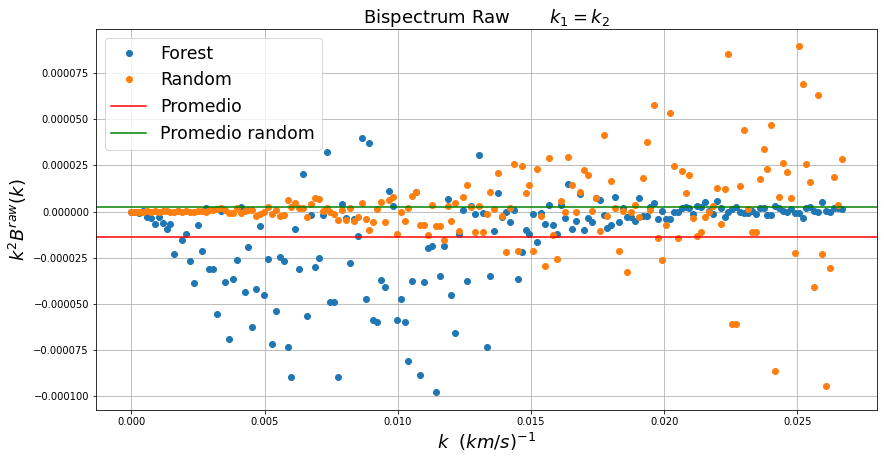

In [109]:
%pylab inline
plt.figure(figsize=(14,7))
plt.title('Bispectrum Raw       $k_{1} = k_{2}$',fontsize = 18)
plt.plot(mkb1,(mkb1**2) * mBsp1,'o', label = 'Forest')
plt.plot(mkb1,(mkb1**2) * mbarE,'o', label = 'Random')
#plt.xscale('log')
#plt.yscale('log')
axhline(np.mean((mk1d[:mk1d[mask1].size]**2) * mBsp1), color = 'r', label = 'Promedio')
axhline(np.mean((mk1d[:mk1d[mask1].size]**2) * mbarE), color = 'g', label = 'Promedio random')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$k^{2}B^{raw}(k)$',fontsize = 18)
plt.legend(fontsize='xx-large')
plt.grid()

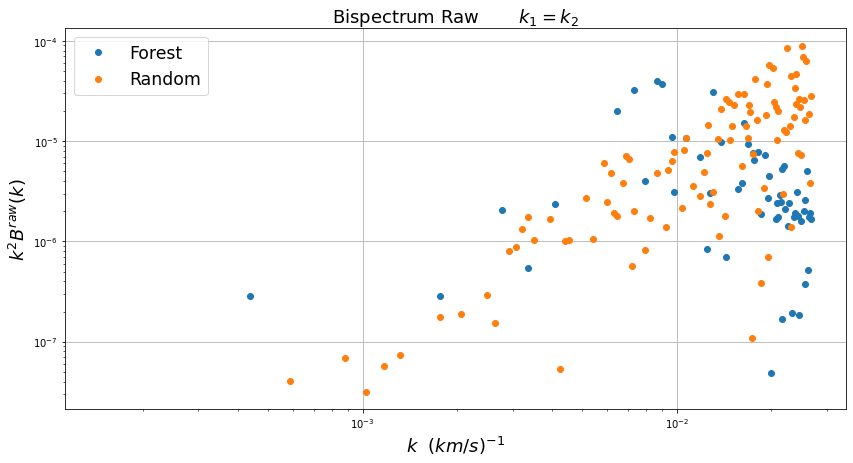

In [110]:
plt.figure(figsize=(14,7))
plt.title('Bispectrum Raw       $k_{1} = k_{2}$',fontsize = 18)
plt.plot(mkb1,(mkb1**2) * mBsp1,'o', label = 'Forest')
plt.plot(mkb1,(mkb1**2) * mbarE,'o', label = 'Random')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k$  $(km/s)^{-1}$',fontsize = 18)
plt.ylabel('$k^{2}B^{raw}(k)$',fontsize = 18)
plt.legend(fontsize='xx-large')
plt.grid()